<br>
# ** 6 Predict the TimeSeries Data**
시계열 데이터 예측

<br><br>
## ** 4 Keras 를 활용한 주가예측**

### **00 주가데이터 가져오기**
> from pandas_datareader import get_data_yahoo

In [1]:
# from pandas_datareader import get_data_yahoo
# price = get_data_yahoo('005930.KS','2017-06-01')
# price = price.fillna('ffill')
# price = price.dropna()
# price.tail(3)

In [2]:
# 저장된 CSV 파일을 사용한다

import pandas as pd
price = pd.read_csv('./data/stock.csv')
price = price.set_index('Date')
price.index = pd.DatetimeIndex(price.index)
price.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-06-07,51800.0,50500.0,51800.0,50600.0,13590016.0,50600.0
2018-06-08,50400.0,49600.0,50200.0,49650.0,16951706.0,49650.0
2018-06-11,50300.0,49350.0,49750.0,49900.0,10496083.0,49900.0


<br>
### ** 01 데이터 전처리**

In [3]:
dataset = price.reset_index()
dataset.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-06-01,44900.0,44400.0,44860.0,44680.0,9753500.0,11621.890625
1,2017-06-02,45960.0,45000.0,45060.0,45960.0,12488750.0,11954.835938


In [4]:
dataset = price.reset_index()
del dataset['Date']
del dataset['Volume']
del dataset['Adj Close']
dataset.columns = ['Open','High','Low','Close']
dataset.tail(3)

,Open,High,Low,Close
245,51800.0,50500.0,51800.0,50600.0
246,50400.0,49600.0,50200.0,49650.0
247,50300.0,49350.0,49750.0,49900.0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


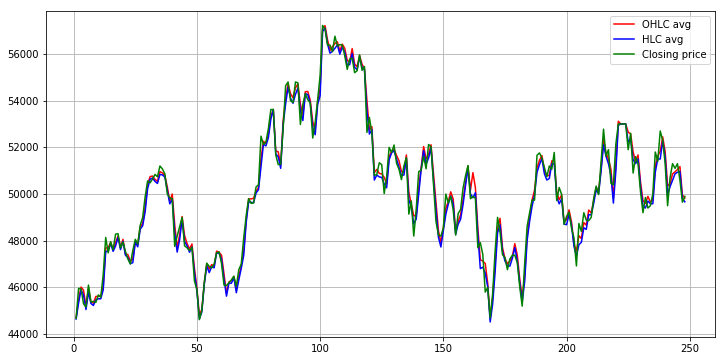

In [6]:
np.random.seed(7)  

obs       = np.arange(1, len(dataset) + 1, 1)
OHLC_avg  = dataset.mean(axis = 1)           
HLC_avg   = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
plt.figure(figsize=(12,6))
plt.plot(obs, OHLC_avg,  'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg,   'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

In [7]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg), 1) )
print("일평균 데이터 : {},\n {}".format( OHLC_avg[:5], type(OHLC_avg)))

scaler   = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)  
print("정규화 데이터 : {}, {}".format(type(OHLC_avg), OHLC_avg[:5]) )

일평균 데이터 : [[44710.]
 [45495.]
 [46015.]
 [45885.]
 [45185.]],
 <class 'numpy.ndarray'>
정규화 데이터 : <class 'numpy.ndarray'>, [[0.00199601]
 [0.06467066]
 [0.10618762]
 [0.09580838]
 [0.03992016]]


In [8]:
def new_dataset(dataset, step_size):
    import numpy as np 
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        data_X.append(dataset[i : (i+step_size), 0])  
        data_Y.append(dataset[i + step_size,     0])
    return np.array(data_X), np.array(data_Y)

train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC  = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY   = new_dataset(test_OHLC, 1)
print(trainX.shape, trainY.shape)  
print(trainX[1], trainY[1])

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX,  (testX.shape[0],  1, testX.shape[1]))
trainX.shape, testX.shape

(184, 1) (184,)
[0.06467066] 0.1061876247504987


((184, 1, 1), (60, 1, 1))

<br>
### ** 02 LSTM 모델 만들기**

In [9]:
step_size = 1
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 5s - loss: 0.0883
Epoch 2/10
 - 1s - loss: 0.0189
Epoch 3/10
 - 1s - loss: 0.0064
Epoch 4/10
 - 1s - loss: 0.0040
Epoch 5/10
 - 1s - loss: 0.0043
Epoch 6/10
 - 1s - loss: 0.0040
Epoch 7/10
 - 2s - loss: 0.0039
Epoch 8/10
 - 2s - loss: 0.0039
Epoch 9/10
 - 2s - loss: 0.0042
Epoch 10/10
 - 2s - loss: 0.0039


In [10]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY       = scaler.inverse_transform([trainY])
testPredict  = scaler.inverse_transform(testPredict)
testY        = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore  = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train RMSE: {:.2f}\nTest  RMSE: {:.2f}'.format(trainScore, testScore))

Train RMSE: 932.48
Test  RMSE: 805.97


<br>
### ** 03 완성된 LSTM 모델의 예측결과 시각화**

In [11]:
trainPredictPlot          = np.empty_like(OHLC_avg)
trainPredictPlot[ : , : ] = np.nan
trainPredictPlot[step_size : len(trainPredict) + step_size , : ] = trainPredict

testPredictPlot       = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (step_size*2) + 1 : len(OHLC_avg) - 1 , : ] = testPredict

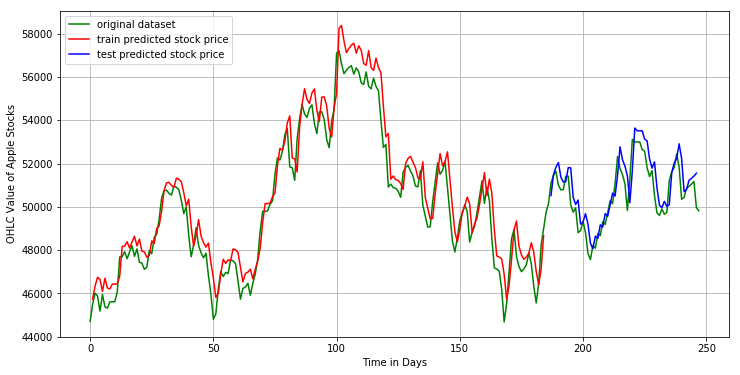

In [12]:
OHLC_avg = scaler.inverse_transform(OHLC_avg)

plt.figure(figsize=(12,6))
plt.plot(OHLC_avg,         'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'train predicted stock price')
plt.plot(testPredictPlot,  'b', label = 'test predicted stock price')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.legend(loc = 'upper left')
plt.grid(); plt.show()

<br>
### ** 04 완성된 LSTM 모델로 내일의 주가 예측**

In [13]:
last_val        = testPredict[-1:]
last_val_scaled = last_val / last_val
next_val        = model.predict(np.reshape(last_val_scaled, (1,1,1)))
last_price      = np.asscalar(last_val)
next_price      = np.asscalar(last_val * next_val)
print ("마지막 예측가격 : {} \n다음날 예측가격 : {} \n증감률 : {}".format(
        last_price, 
        next_price, 
        (next_price - last_val) / last_val) )

마지막 예측가격 : 51552.80078125 
다음날 예측가격 : 56359.62890625 
증감률 : [[0.09324087]]
